# Lab 6: Smart Hotel Energy Optimization

**Context:** Energy consumption in Hotel
**Objective:** Reduce hotel energy consumption while maintaining comfort  
**Data:** Sample IoT sensor data (AC usage, occupancy, time, outdoor temperature)  
**AI Method:** Lightweight regression (Green AI) + simple optimization rules  
**Sustainability Link:** Explicit SDG alignment → **SDG 12** (Responsible Consumption) & **SDG 13** (Climate Action)

---

## What we will build

1. Simulate hourly IoT-style data: **occupancy, outdoor temperature, AC setpoint, AC on/off, energy (kWh)**
2. Train a simple **linear regression** (fast, explainable → Green AI)
3. Apply **optimization rules** (smart control policy)
4. Estimate energy and CO₂ savings
5. Plot **before vs after** energy usage



## Input Data (Very Short)

This lab uses **simulated IoT sensor data** representing a hotel located at **Lakeside Pokhara**.  
Each row corresponds to **one hour of operation**.

**Input variables:**
- **timestamp** – date and hour of observation  
- **hour** – hour of the day (0–23)  
- **is_weekend** – weekend indicator (0 = weekday, 1 = weekend)  
- **temp_out** – outdoor temperature in °C  
- **occupancy** – fraction of rooms occupied (range: 0–1)  
- **setpoint** – AC temperature setting in °C  
- **ac_on** – AC status (1 = ON, 0 = OFF)  
- **kwh** – energy consumed in that hour (kWh)

---

## Steps Performed in the Lab

1. **Simulate IoT Data**  
   Generate realistic hourly hotel data (occupancy, temperature, AC usage).

2. **Feature Construction**  
   Prepare input features using time, weekend flag, temperature, occupancy, and AC settings.

3. **Train Regression Model (Green AI)**  
   Fit a simple linear regression model to predict hourly energy consumption.

4. **Design Smart Control Rules**  
   Define rule-based policies to reduce unnecessary AC usage.

5. **Apply Optimization Policy**  
   Modify AC setpoints and ON/OFF status based on occupancy and outdoor temperature.

6. **Estimate Energy After Optimization**  
   Predict energy usage after applying the smart control rules.

7. **Compute Energy and CO₂ Savings**  
   Calculate total energy saved (kWh) and corresponding CO₂ reduction.

8. **Visualize Results**  
   Plot and compare energy usage before and after optimization.

---

## Assumptions Made

- Occupancy values are normalized between **0 and 1**.
- Higher occupancy leads to **higher energy consumption**.
- Lower AC setpoints result in **higher cooling energy usage**.
- If occupancy is very low or zero, the **AC can be turned OFF**.
- Guest comfort is maintained by limiting excessive setpoint increases.
- CO₂ emissions are estimated using a **fixed emission factor** (illustrative).
- A simple regression model is used to follow **Green AI principles**.

---

## Sustainability Link

- **SDG 12 – Responsible Consumption and Production:**  
  Reduces unnecessary hotel energy usage.

- **SDG 13 – Climate Action:**  
  Lower energy use leads to reduced carbon emissions.



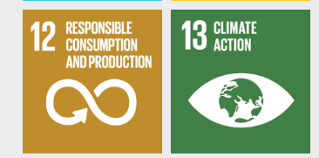

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive/')

## set a folder as current working dir
os.chdir('/content/drive/My Drive/AI4T/sustainable-smart-tourism/')


Mounted at /content/drive/


In [ ]:
# Install note:
# This notebook uses only standard libraries available in Colab by default.
# If you are running elsewhere and something is missing, install with pip.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Functions

We organize the lab into small functions:

- `fit_linear_regression_closed_form(X, y)` → trains a lightweight model using NumPy
- `predict_linear_regression(X, beta)` → makes predictions
- `apply_smart_control_rules(df)` → applies optimization rules (policy)
- `estimate_energy_after_policy(...)` → estimates kWh after applying rules
- `summarize_savings(...)` → computes kWh and CO₂ savings
- `plot_before_after(...)` → plots results (matplotlib)


In [ ]:


def build_feature_matrix(df, setpoint_col="setpoint", ac_on_col="ac_on"):
    """Create regression feature matrix X and target y.

    Model features (simple + explainable):
    - hour
    - is_weekend
    - temp_out
    - occupancy
    - setpoint
    - ac_on
    """
    X = df[["hour", "is_weekend", "temp_out", "occupancy"]].copy()
    X["setpoint"] = df[setpoint_col]
    X["ac_on"] = df[ac_on_col]
    X.insert(0, "bias", 1.0)  # intercept term
    y = df["kwh"].values.reshape(-1, 1)
    return X.values, y


def fit_linear_regression_closed_form(X, y):
    """Fit linear regression using closed-form (normal equation).

    beta = (X^T X)^(-1) X^T y
    """
    return np.linalg.inv(X.T @ X) @ (X.T @ y)


def predict_linear_regression(X, beta):
    """Predict using learned linear regression coefficients."""
    return (X @ beta).flatten()


def apply_smart_control_rules(df,
                             occ_low=0.20,
                             occ_empty=0.05,
                             setpoint_raise=2.0,
                             mild_temp=20.0,
                             occ_high_for_mild=0.60,
                             setpoint_min=20.0,
                             setpoint_max=26.0):
    """Apply simple rule-based smart control policy.

    Rules (explainable):
    1) If occupancy is low (< occ_low): increase setpoint by +setpoint_raise (less cooling)
    2) If occupancy is basically empty (< occ_empty): AC off
    3) If outdoor temperature is mild (< mild_temp) and occupancy not high: AC off

    Returns
    -------
    df_opt : DataFrame
        Copy of df with new columns:
        - setpoint_opt
        - ac_on_opt
    """
    df_opt = df.copy()
    df_opt["setpoint_opt"] = df_opt["setpoint"]
    df_opt.loc[df_opt["occupancy"] < occ_low, "setpoint_opt"] = df_opt.loc[df_opt["occupancy"] < occ_low, "setpoint_opt"] + setpoint_raise
    df_opt["setpoint_opt"] = np.clip(df_opt["setpoint_opt"], setpoint_min, setpoint_max)

    df_opt["ac_on_opt"] = df_opt["ac_on"]
    df_opt.loc[df_opt["occupancy"] < occ_empty, "ac_on_opt"] = 0
    df_opt.loc[(df_opt["temp_out"] < mild_temp) & (df_opt["occupancy"] < occ_high_for_mild), "ac_on_opt"] = 0

    return df_opt


def estimate_energy_after_policy(df_opt, beta):
    """Estimate kWh after applying policy using the trained regression model."""
    X_opt, _ = build_feature_matrix(df_opt, setpoint_col="setpoint_opt", ac_on_col="ac_on_opt")
    df_opt["kwh_after"] = predict_linear_regression(X_opt, beta)
    return df_opt


def summarize_savings(df_before, df_after, emission_factor=0.45):
    """Compute energy and CO2 savings.

    emission_factor: kg CO2 per kWh (teaching value; adjust if you have a better one)
    """
    total_before = df_before["kwh"].sum()
    total_after = df_after["kwh_after"].sum()

    savings_kwh = total_before - total_after
    savings_pct = (savings_kwh / total_before) * 100 if total_before > 0 else 0.0
    co2_saved = savings_kwh * emission_factor

    summary = {
        "Total kWh (Before)": total_before,
        "Total kWh (After)": total_after,
        "Savings (kWh)": savings_kwh,
        "Savings (%)": savings_pct,
        "CO2 Saved (kg)": co2_saved
    }
    return summary


def plot_before_after(df_before, df_after, n_hours=72):
    """Plot before vs after energy usage (first n_hours)."""
    plt.figure()
    plt.plot(df_before["timestamp"][:n_hours], df_before["kwh"][:n_hours], label="Before (measured/simulated)")
    plt.plot(df_after["timestamp"][:n_hours], df_after["kwh_after"][:n_hours], label="After (policy estimate)")
    plt.title(f"Hotel Energy (kWh/hour): Before vs After Policy (first {n_hours} hours)")
    plt.xlabel("Time")
    plt.ylabel("kWh per hour")
    plt.xticks(rotation=25, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Execute

### Step A: Read IoT data ( Hotel energy consumption data)


In [ ]:
df=pd.read_csv('iot_data_Hotel_X.csv')
df.head(8)

,timestamp,hour,dayofweek,is_weekend,temp_out,occupancy,setpoint,ac_on,kwh
0,2026-01-01 00:00:00,0,3,0,19.183368,0.431258,22.124404,0,0.202414
1,2026-01-01 01:00:00,1,3,0,18.709120,0.284703,22.029257,1,1.169734
2,2026-01-01 02:00:00,2,3,0,20.022974,0.392063,21.939366,0,0.387262
3,2026-01-01 03:00:00,3,3,0,21.113689,0.389148,21.292505,1,1.100957
4,2026-01-01 04:00:00,4,3,0,20.911855,0.542610,22.019508,1,1.258181
5,2026-01-01 05:00:00,5,3,0,21.865149,0.314849,21.586986,0,0.335872
6,2026-01-01 06:00:00,6,3,0,21.999377,0.286804,22.016716,1,1.271613
7,2026-01-01 07:00:00,7,3,0,20.635396,0.348306,22.186020,0,0.232532


### Step B: Train a lightweight regression model (Green AI)

We fit linear regression using NumPy:
- Fast
- Explainable
- Low compute cost (Green AI)


In [ ]:
X, y = build_feature_matrix(df, setpoint_col="setpoint", ac_on_col="ac_on")
beta = fit_linear_regression_closed_form(X, y)

df["kwh_pred"] = predict_linear_regression(X, beta)

mae = np.mean(np.abs(df["kwh"] - df["kwh_pred"]))
print(f"Regression MAE (kWh): {mae:.3f}")


Regression MAE (kWh): 0.070


### Step C: Apply smart control rules (optimization policy)

Policy idea:
- If occupancy is low → increase setpoint (use less cooling)
- If empty → AC OFF
- If outdoor temp is mild → reduce AC usage


In [ ]:
df_opt = apply_smart_control_rules(
    df,
    occ_low=0.20,
    occ_empty=0.05,
    setpoint_raise=2.0,
    mild_temp=20.0,
    occ_high_for_mild=0.60
)

df_opt = estimate_energy_after_policy(df_opt, beta)

df_opt[["timestamp","occupancy","temp_out","setpoint","ac_on","kwh","setpoint_opt","ac_on_opt","kwh_after"]].head(12)


,timestamp,occupancy,temp_out,setpoint,ac_on,kwh,setpoint_opt,ac_on_opt,kwh_after
0,2026-01-01 00:00:00,0.431258,19.183368,22.124404,0,0.202414,22.124404,0,0.338915
1,2026-01-01 01:00:00,0.284703,18.709120,22.029257,1,1.169734,22.029257,0,0.312746
2,2026-01-01 02:00:00,0.392063,20.022974,21.939366,0,0.387262,21.939366,0,0.338844
3,2026-01-01 03:00:00,0.389148,21.113689,21.292505,1,1.100957,21.292505,1,1.257089
4,2026-01-01 04:00:00,0.542610,20.911855,22.019508,1,1.258181,22.019508,1,1.282616
5,2026-01-01 05:00:00,0.314849,21.865149,21.586986,0,0.335872,21.586986,0,0.338119
6,2026-01-01 06:00:00,0.286804,21.999377,22.016716,1,1.271613,22.016716,1,1.244746
7,2026-01-01 07:00:00,0.348306,20.635396,22.186020,0,0.232532,22.186020,0,0.339973
8,2026-01-01 08:00:00,0.060101,22.176462,21.729690,0,0.394771,23.729690,0,0.292227
9,2026-01-01 09:00:00,0.102819,21.248776,21.590772,1,1.160441,23.590772,1,1.208658


### Step D: Summarize energy and CO₂ savings (SDG 12 + SDG 13)

- **SDG 12:** less energy waste (responsible consumption)
- **SDG 13:** fewer emissions (climate action)

> Note: CO₂ conversion uses an illustrative emission factor (kg CO₂/kWh). Replace with a better local value if available.


In [ ]:
summary = summarize_savings(df, df_opt, emission_factor=0.45)
pd.DataFrame([summary])


,Total kWh (Before),Total kWh (After),Savings (kWh),Savings (%),CO2 Saved (kg)
0,236.635989,174.241085,62.394904,26.367462,28.077707


### Step E: Plot before vs after (first 72 hours)


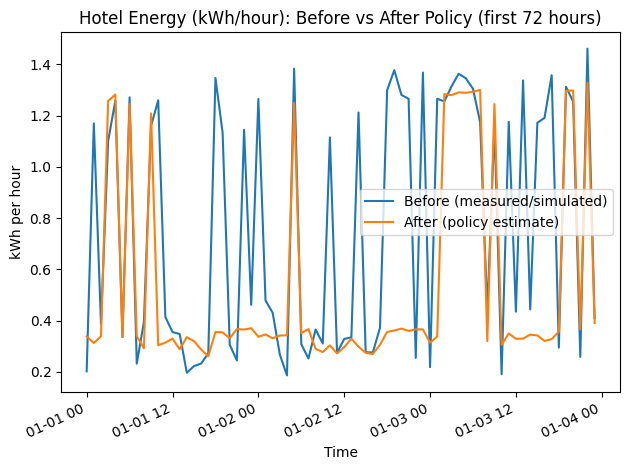

In [ ]:
plot_before_after(df, df_opt, n_hours=72)


## 3) Student Exercises (Recommended)

1. **Tune policy thresholds**:
   - Change `occ_low` from 0.20 to 0.30 and compare savings
2. **Comfort constraint**:
   - Do not raise setpoint when `occupancy > 0.6`
3. **Green AI discussion**:
   - Compare a simple model vs a more complex one (accuracy vs compute cost)

---

## 4) What to Submit (Lab Report)

- Table: summary (kWh before/after, savings %, CO₂ saved)
- One plot: before vs after
- 5–8 lines: explain how the rules support **SDG 12 and SDG 13**
